# Practice Model: A Simple Starter

### Building a GP where 

$
\begin{align}
\Delta \nu \sim \mathcal{GP}(f(mass), k(mass,mass^{\prime}))
\end{align}
$

We'll start out by using `numpy` as a test to prove to ourselves that we understand GP implementations in general.

> We are looking for the functional form so that we can implement the likelihood calculation later.  
The independent parameter is mass and the observed is $\Delta$$\nu$

***

### Some assumptions

In the first place, since this is a "simple" starter model, we can make some decisions before we even start to guide the process of implementing the model. Let's start with a fairly common GP, where the mean function is zero and the covariance function is a squared exponential. Why? Because that's where everyone starts from.

This squared exponential says that values of $mass$ and $mass^\prime$ that are close to each other result in values of $k$ closer to 1. This ends up looking like a diagonal covariance matrix. 

Let's talk about why that makes sense -HERE-

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Our observed value is $\Delta$$\nu$ - for now we'll call it `Dnu` for ease of typing  
Our independent parameter is `mass` - this is a perfectly fine variable name, but remember that if you're following a tutorial for more complicated GP implementations, it's likely to be called $x$ 

Let's have a look at the dataset given:

In [2]:
data = np.loadtxt('./Lindsey_version1.csv', delimiter=',', skiprows=1)
Dnu = data[:,1]
mass = data [:, 0]

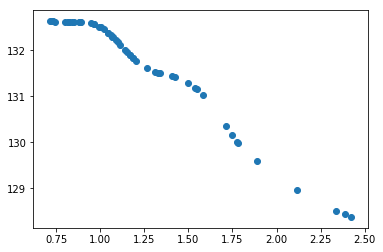

In [3]:
# TODO: Make this not as awful
fig, ax = plt.subplots()
ax.scatter(mass, Dnu)

What we think we see in this plot is a relationship between stellar mass and observed $\Delta$$\nu$.  
That is, this plot looks like it's trying to inform us that the large frequency separation decreases as stellar mass increases  
It's also a really bad looking plot, but `TODO`: fix it later  

*** 

Our goal is to try to find a good (even if it's wrong) posterior estimate of the functional form.  
Posterior estimate: "the shaded region" <- what I think of as 'the area under the curve' except it's a space shaped by the mean function, constrained by observed points, and bounded by the standard deviation

***

### Gaussian process in numpy

_Step 1: Start with a prior_  
_Step 2: Compute the posterior_  
_Step 3: Sample and compare_  

 [ ] Construct a vector of test inputs evenly spaced so as to seem continuous ($X$$_*$, or mass$_*$)  
 [ ] Define the kernel function - Squared Exponential kernel  
 [ ] Figure out the hyperparameters $\sigma$$_f$$^2$ and length scale  
 [ ] Use the kernel function to create the matrices for computing the covariance and the mean of the posterior ($cov$($f_*$) & $\mu$)  
 

***

### Some useful definitions before we move on:

##### Hyperparameter:

parameters of the covariance function; "kernel parameters" are hyperparameters

##### Overfitting/Overfitted Model:

a statistical model that contains more parameters than are justified by the data; a model that "memorizes" training data instead of "learning" a trend

##### Placeholer:

some thing that I would benefit from having a definition that's easy to flip back to in moments of foggy understanding

***  

The function below is from [Martin Krasser on GitHub](https://github.com/krasserm/bayesian-machine-learning/blob/af6882305d9d65dbbf60fd29b117697ef250d4aa/gaussian_processes_util.py#L7)

In [5]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    """
    from the Bayesian Machine Learning notebooks page 
    """
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.3)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

#### Squared Exponential Covariance

There seems to be some weird lack of consensus about what the squared exponential looks like.  

Rasmussen+(2006) has the form  
$k(x_p, x_q) = \sigma^2_p \Sigma \phi_c(x_p)\phi_c(x_q)  $

or  $\sqrt\pi \ell \sigma^2_p exp(-\frac {(x_p - x_q)^2}{2(\sqrt2 \ell)^2})$  
  
<br><br>
PyMC3 has the form  

$k(x, x') = exp[\frac{-(x - x')^2}{2\ell^2}]$  
But I'm not really sure where the $\sigma^2$ term went, how they've implemented things... is it assumed to be 1?

<br><br>
There's also  
$k(x_i, x_j) = \sigma^2_f exp(\frac {-1}{2\ell^2} (x_i - x_j)^T(x_i - x_j))  $  
And I'm using this one today

<br><br>
And I've seen  
$k(x, x') = \sigma^2_f e^{-\frac{1}{2\ell^2}\Vert{x - x'}^2\Vert}$

In [6]:
def exponential_cov(x1, x2, sigma_f, ls):
    """
    Note the cdist function exists for x1 and x2 that are 2D arrays
    """
    square_dist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp((-1/(2 * ls**2)) * square_dist)

Above, we define the kernel  

Below, we define a way to compute the posterior with training data  
There are some other syntax inconsistencies in the documentation and examples floating around; I've done a little to keep them straight, but other than being overly verbose at all times there's no straightforward fix

This bit is sometimes written with matrices labeled A, B, C  
Sometimes it's written K, K_s, and K_ss  

I don't know which I prefer, but K_ is easy to read at a glance

In [7]:
from numpy.linalg import inv

def posterior_pred(X_s, X_train, Y_train, sigma_f, ls, sigma_y=1e-8):
    """
    Note: the _s is represented as a _* in Rassmussen+(2006); so mu_s is $f_*$ in the given equations
    """
    K = exponential_cov(X_train, X_train, sigma_f, ls) + sigma_y**2 * np.eye(len(X_train))
    K_s = exponential_cov(X_train, X_s, sigma_f, ls)
    K_ss = exponential_cov(X_s, X_s, sigma_f, ls) + 1e-8 * np.eye(len(X_s))
    
    
    # Rassmussen+(2006) eq. 2.23 - GP posterior mean 
    mu_s = K_s.T.dot(inv(K)).dot(Y_train)
    
    # Rassmussen+(2006) eq. 2.24 - GP posterior covariance
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    
    return mu_s, cov_s

### Can we sample the posterior yet?  

Yet another placeholder for an informative comment!

In [106]:
# there are 53 points of data, so let's try 3k test points in the vector?
X = np.linspace(.71, 2.5, 3000).reshape(-1, 1)

# just call the hyperparameters what they are because there's no need to be so obfuscating folks
sigma2 =  20 # variance of the (noise free) signal; as latex $\sigma$$_f$$^2$
length_scale = 0.8

In [107]:
mu_s, cov_s = posterior_pred(X, mass.reshape(-1, 1), Dnu, sigma2, length_scale, .8)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

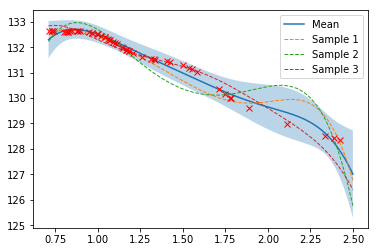

In [108]:
plot_gp(mu_s, cov_s, X, mass, Dnu, samples=samples)

That looks pretty rough. What makes it pull so hard on the right-hand side?